#LOAD SHEDDING PREDICTION - MODEL TRAINING COMPLETE PIPELINE


Project: Addressing the Limitations of Reactive Load Shedding Schedules
Author: Bonyu Miracle Glen
Institution: African Leadership University


COMPLETE MODEL TRAINING PIPELINE
- Baseline Models: Logistic Regression, Random Forest, XGBoost
- Deep Learning: LSTM, Bidirectional LSTM
- Comprehensive Comparison and Visualization

Input:  featured_data.csv (~36,000 rows × 90 features)
Output: Trained models, metrics, visualizations




# SECTION 1: SETUP AND IMPORTS

In [ ]:
print("="*70)
print("MODEL TRAINING - COMPLETE PIPELINE")
print("="*70)
print("\n[1/12] Setting up environment...\n")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

print(" Libraries imported!")
print(f"\n TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

if tf.config.list_physical_devices('GPU'):
    print(" GPU detected - LSTM will train fast!")
else:
    print("⚠️ No GPU - LSTM will be slower")
    print("   Tip: Runtime → Change runtime type → GPU")

# Paths
import os
project_dir = '/content/drive/MyDrive/LoadShedding_Capstone'
data_dir = f'{project_dir}/data'
output_dir = f'{project_dir}/outputs'
models_dir = f'{project_dir}/models'
os.makedirs(models_dir, exist_ok=True)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("\n✅ Setup complete!")


MODEL TRAINING - COMPLETE PIPELINE

[1/12] Setting up environment...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Libraries imported!

 TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 GPU detected - LSTM will train fast!

✅ Setup complete!


# SECTION 2: DATA LOADING


In [ ]:

print("\n" + "="*70)
print("[2/12] Loading featured data...")
print("="*70)

df = pd.read_csv(f'{data_dir}/featured_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"\n✅ Loaded: {len(df):,} rows × {len(df.columns)} columns")
print(f"   Range: {df['datetime'].min()} to {df['datetime'].max()}")

print(f"\n Target distribution:")
for stage in sorted(df['stage'].unique()):
    count = (df['stage'] == stage).sum()
    pct = count / len(df) * 100
    print(f"   Stage {int(stage)}: {count:>6,} ({pct:>5.1f}%)")




[2/12] Loading featured data...

✅ Loaded: 36,143 rows × 86 columns
   Range: 2021-04-01 00:00:00 to 2025-05-15 22:00:00

 Target distribution:
   Stage 0: 22,839 ( 63.2%)
   Stage 1:    993 (  2.7%)
   Stage 2:  3,873 ( 10.7%)
   Stage 3:  2,992 (  8.3%)
   Stage 4:  3,242 (  9.0%)
   Stage 5:    873 (  2.4%)
   Stage 6:  1,331 (  3.7%)


# SECTION 3: TRAIN/TEST SPLIT


In [ ]:

print("\n" + "="*70)
print("[3/12] Creating train/test split...")
print("="*70)

split_idx = int(len(df) * 0.80)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"\n✅ Split (80/20 temporal):")
print(f"   Train: {len(train_df):,} rows")
print(f"   Test:  {len(test_df):,} rows")




[3/12] Creating train/test split...

✅ Split (80/20 temporal):
   Train: 28,914 rows
   Test:  7,229 rows


# SECTION 3B: ADD PREDICTION HORIZON
 (CRITICAL FOR REAL FORECASTING!)

Why this matters:

*   Businesses get 6-hour advance warning
*   Model can't `cheat` by using concurrent measurements



In [ ]:

print("\n" + "="*70)
print("[3B] ADDING 6-HOUR PREDICTION HORIZON")
print("="*70)

PREDICTION_HORIZON = 6  # Predict 6 hours ahead

# Create future target by shifting stage forward
print(f" Creating target: stage {PREDICTION_HORIZON} hours in the future...")
train_df = train_df.copy()
test_df = test_df.copy()

train_df['stage_future'] = train_df['stage'].shift(-PREDICTION_HORIZON)
test_df['stage_future'] = test_df['stage'].shift(-PREDICTION_HORIZON)

# Remove last H rows (no future data available)
train_df = train_df.iloc[:-PREDICTION_HORIZON].copy()
test_df = test_df.iloc[:-PREDICTION_HORIZON].copy()

# Remove any NaN in future target
train_df = train_df.dropna(subset=['stage_future'])
test_df = test_df.dropna(subset=['stage_future'])

print(f"\n Prediction horizon applied:")
print(f"   Train samples: {len(train_df):,} (lost {PREDICTION_HORIZON} from end)")
print(f"   Test samples: {len(test_df):,} (lost {PREDICTION_HORIZON} from end)")

print(f"\n Forecasting example:")
print(f"   Sample row from data:")
sample_idx = len(train_df) // 2
print(f"   Features at:    {train_df.iloc[sample_idx]['datetime']}")
print(f"   Current stage:  {int(train_df.iloc[sample_idx]['stage'])}")
print(f"   Predict stage:  {int(train_df.iloc[sample_idx]['stage_future'])} (6 hours later)")

print(f"\n✅ This is now TRUE 6-hour ahead forecasting!")
print("="*70)


[3B] ADDING 6-HOUR PREDICTION HORIZON
 Creating target: stage 6 hours in the future...

 Prediction horizon applied:
   Train samples: 28,908 (lost 6 from end)
   Test samples: 7,223 (lost 6 from end)

 Forecasting example:
   Sample row from data:
   Features at:    2022-11-24 06:00:00
   Current stage:  2
   Predict stage:  2 (6 hours later)

✅ This is now TRUE 6-hour ahead forecasting!


## VERIFY SHIFT WORKED - CHECK 2023 DATA

In [ ]:

print("\n" + "="*70)
print("🔍 VERIFYING SHIFT ON 2023 DATA (WHERE LOAD SHEDDING EXISTS)")
print("="*70)

# Find indices in 2023 (where heavy load shedding occurred)
mask_2023 = (train_df['datetime'] >= '2023-01-01') & (train_df['datetime'] < '2024-01-01')
indices_2023 = train_df[mask_2023].index.tolist()

if len(indices_2023) > 0:
    print(f"\n✅ Found {len(indices_2023)} rows in 2023")
    print("\n📊 Checking if shift worked (looking at 2023 data):")
    print("\n   Index  | datetime            | stage | stage_future | Shifted?")
    print("   " + "-"*70)

    # Check 10 samples from 2023
    sample_indices = indices_2023[::len(indices_2023)//10][:10]

    for idx in sample_indices:
        row = train_df.loc[idx]

        # Get the actual value 6 hours later
        if idx + 6 < len(train_df):
            actual_6h_later = train_df.iloc[train_df.index.get_loc(idx) + 6]['stage']
        else:
            actual_6h_later = -999

        match = "✅ CORRECT" if row['stage_future'] == actual_6h_later else "❌ WRONG"
        different = "✅ Different" if row['stage'] != row['stage_future'] else "⚠️ Same"

        print(f"   {idx:6d} | {row['datetime']} | {int(row['stage']):5d} | {int(row['stage_future']):12d} | {different}")

    # Critical check: Are ANY different?
    different_count = (train_df['stage'] != train_df['stage_future']).sum()
    print(f"\n   Rows where stage ≠ stage_future: {different_count:,} / {len(train_df):,}")

    if different_count == 0:
        print("\n   ❌ CRITICAL ERROR: stage_future is identical to stage!")
        print("      The shift operation FAILED!")
    elif different_count < len(train_df) * 0.1:
        print(f"\n   ⚠️ WARNING: Only {different_count/len(train_df)*100:.1f}% are different")
        print("      Stages might be too persistent (change slowly)")
    else:
        print(f"\n   ✅ GOOD: {different_count/len(train_df)*100:.1f}% are different")
        print("      Shift appears to be working!")
else:
    print("\n❌ No 2023 data found in training set!")

print("\n" + "="*70)


🔍 VERIFYING SHIFT ON 2023 DATA (WHERE LOAD SHEDDING EXISTS)

✅ Found 8760 rows in 2023

📊 Checking if shift worked (looking at 2023 data):

   Index  | datetime            | stage | stage_future | Shifted?
   ----------------------------------------------------------------------
    15360 | 2023-01-01 00:00:00 |     2 |            2 | ⚠️ Same
    16236 | 2023-02-06 12:00:00 |     3 |            4 | ✅ Different
    17112 | 2023-03-15 00:00:00 |     4 |            3 | ✅ Different
    17988 | 2023-04-20 12:00:00 |     5 |            6 | ✅ Different
    18864 | 2023-05-27 00:00:00 |     5 |            3 | ✅ Different
    19740 | 2023-07-02 12:00:00 |     0 |            3 | ✅ Different
    20616 | 2023-08-08 00:00:00 |     4 |            1 | ✅ Different
    21492 | 2023-09-13 12:00:00 |     6 |            6 | ⚠️ Same
    22368 | 2023-10-20 00:00:00 |     0 |            0 | ⚠️ Same
    23244 | 2023-11-25 12:00:00 |     6 |            6 | ⚠️ Same

   Rows where stage ≠ stage_future: 5,901 / 

# SECTION 4: FEATURE PREPARATION & DATA LEAKAGE FIX

In [ ]:

print("\n" + "="*70)
print("[4/12] Preparing features for baseline models...")
print("="*70)

# Separate features and target
feature_cols = [col for col in df.columns if col not in ['datetime', 'stage', 'stage_future']]

print(f"\n📊 Initial feature count: {len(feature_cols)}")


# ============================================================================
# COMPREHENSIVE DATA LEAKAGE FIX
# ============================================================================

print("\n" + "="*70)
print("🔧 COMPREHENSIVE DATA LEAKAGE FIX")
print("="*70)

print("\n⚠️ Removing features that cause leakage:")


# Comprehensive list of leakage features
leakage_features = [
    # Stage-derived features
    'stage_lag_1h',
    'stage_lag_6h',
    'stage_lag_24h',
    'stage_lag_168h',
    'stage_rolling_3h',
    'stage_rolling_6h',
    'stage_rolling_12h',
    'stage_rolling_24h',
    'stage_change_1h',
    'stage_rolling_std_24h',
    'stage_rolling_max_24h',
    'stage_rolling_min_24h',

    # MLR features (concurrent)
    'Manual Load_Reduction(MLR)',
    'Manual Load_Reduction(MLR)_lag_1h',
    'Manual Load_Reduction(MLR)_lag_6h',
    'Manual Load_Reduction(MLR)_lag_24h',
    'Manual Load_Reduction(MLR)_lag_168h',
    'Manual Load_Reduction(MLR)_rolling_3h',
    'Manual Load_Reduction(MLR)_rolling_6h',
    'Manual Load_Reduction(MLR)_rolling_12h',
    'Manual Load_Reduction(MLR)_rolling_24h',
    'mlr_x_capacity_loss',

    # demand_gap features (concurrent)
    'demand_gap',
    'demand_gap_lag_1h',
    'demand_gap_lag_6h',
    'demand_gap_lag_24h',
    'demand_gap_lag_168h',
    'demand_gap_rolling_3h',
    'demand_gap_rolling_6h',
    'demand_gap_rolling_12h',
    'demand_gap_rolling_24h',
    'demand_gap_change_1h',

    # NEW: Concurrent demand/generation measurements
    'Residual Demand',              # Measured NOW, not forecasted
    'RSA Contracted Demand',        # Measured NOW, not forecasted
    'Dispatchable Generation',      # Measured NOW, not forecasted

    # Derived features
    'demand_supply_ratio',
    'capacity_x_demand_gap',
]

# count actual removals
removed_count = sum(1 for f in leakage_features if f in feature_cols)

# Filter out leakage features
feature_cols_clean = [f for f in feature_cols if f not in leakage_features]

print(f"\n Feature set summary:")
print(f"   Original features:     {len(feature_cols)}")
print(f"   Removed (leakage):     {removed_count}")
print(f"   Remaining (clean):     {len(feature_cols_clean)}")
print(f"   Reduction:             {removed_count/len(feature_cols)*100:.1f}%")

# Update feature_cols
feature_cols = feature_cols_clean




[4/12] Preparing features for baseline models...

📊 Initial feature count: 84

🔧 COMPREHENSIVE DATA LEAKAGE FIX

⚠️ Removing features that cause leakage:
   1. Stage-derived features (autocorrelation)
   2. MLR features (concurrent emergency response)
   3. demand_gap features (concurrent measurement)
   4. Derived features (based on above)


📊 Feature set summary:
   Original features:     84
   Removed (leakage):     33
   Remaining (clean):     51
   Reduction:             39.3%

✅ Keeping ONLY truly predictive features:
   • Grid conditions (UCLF, Thermal, OCGT, Nuclear)
   • Renewable energy (Wind, PV, CSP)
   • Temporal patterns (hour, day, season)
   • Historical lags of grid metrics (not stage)


📊 Preparing training and test sets...

✅ Feature shapes (after comprehensive leakage removal):
   X_train: (28908, 51) (samples, features)
   y_train: (28908,)
   X_test:  (7223, 51)
   y_test:  (7223,)

🎯 TARGET VERIFICATION:
   Using: train_df['stage_future'] (6 hours ahead)
   NOT 

### PREPARE X AND Y WITH PREDICTION HORIZON TARGET


In [ ]:

print("\n" + "="*70)
print("📊 Preparing training and test sets...")
print("="*70)

# CRITICAL: Use stage_future (6h ahead) as target, NOT current stage!
X_train_raw = train_df[feature_cols].values
y_train = train_df['stage_future'].values  # ✅ Predicting 6 hours ahead!

X_test_raw = test_df[feature_cols].values
y_test = test_df['stage_future'].values     # ✅ Predicting 6 hours ahead!

print(f"\n✅ Feature shapes (after comprehensive leakage removal):")
print(f"   X_train: {X_train_raw.shape} (samples, features)")
print(f"   y_train: {y_train.shape}")
print(f"   X_test:  {X_test_raw.shape}")
print(f"   y_test:  {y_test.shape}")

# Verify we're using the correct target
print(f"\n🎯 TARGET VERIFICATION:")
print(f"   Using: train_df['stage_future'] (6 hours ahead)")
print(f"   NOT using: train_df['stage'] (current)")


# Data quality check
print(f"\n🔍 Data quality check:")
if np.isnan(X_train_raw).sum() > 0 or np.isinf(X_train_raw).sum() > 0:
    print(f"   Cleaning NaN/Inf values...")
    X_train_raw = np.nan_to_num(X_train_raw, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_raw = np.nan_to_num(X_test_raw, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"   ✅ Cleaned")
else:
    print(f"   ✅ No data issues")

### FEATURE SCALING


In [ ]:

print("\n" + "="*70)
print("📏 Scaling features (StandardScaler)...")
print("="*70)

print(f"\n🔄 Standardizing features (mean=0, std=1)...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"\n✅ Features scaled!")
print(f"   Example (first feature):")
print(f"      Before - Mean: {X_train_raw[:, 0].mean():.2f}, Std: {X_train_raw[:, 0].std():.2f}")
print(f"      After  - Mean: {X_train_scaled[:, 0].mean():.2f}, Std: {X_train_scaled[:, 0].std():.2f}")

### SAVE SCALER & FEATURE LIST


In [ ]:

print("\n" + "="*70)
print("💾 Saving artifacts...")
print("="*70)

import joblib

# Save scaler
scaler_path = f'{models_dir}/feature_scaler_final.pkl'
joblib.dump(scaler, scaler_path)
print(f"\n✅ Scaler saved: {scaler_path}")

# Save feature list
feature_list_path = f'{models_dir}/feature_list_final.txt'
with open(feature_list_path, 'w') as f:
    f.write("FINAL CLEAN FEATURE LIST\n")
    f.write("="*70 + "\n\n")
    f.write(f"Total features: {len(feature_cols)}\n")
    f.write(f"Prediction horizon: 6 hours\n")
    f.write(f"Target: stage_future (not stage)\n\n")
    f.write("REMOVED CATEGORIES:\n")
    f.write("  - All stage lags and rolling windows\n")
    f.write("  - Manual Load Reduction (MLR) - all variants\n")
    f.write("  - demand_gap - all variants\n")
    f.write("  - demand_supply_ratio\n")
    f.write("  - All interactions with above\n\n")
    f.write("REMAINING FEATURES:\n")
    f.write("="*70 + "\n\n")
    for i, feat in enumerate(feature_cols, 1):
        f.write(f"{i:3d}. {feat}\n")

print(f"✅ Feature list saved: {feature_list_path}")


# SECTION 5: LOGISTIC REGRESSION


In [ ]:

print("\n" + "="*70)
print("[5/12] Training Logistic Regression...")
print("="*70)

start = time()
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\n✅ Done in {time()-start:.1f}s")
print(f"   Accuracy: {lr_accuracy*100:.2f}%")
print(f"   F1-Score: {lr_f1:.3f}")

joblib.dump(lr_model, f'{models_dir}/logistic_regression.pkl')



[5/12] Training Logistic Regression...

✅ Done in 3.5s
   Accuracy: 81.92%
   F1-Score: 0.885


['/content/drive/MyDrive/LoadShedding_Capstone/models/logistic_regression.pkl']

# SECTION 6: RANDOM FOREST


In [ ]:

print("\n" + "="*70)
print("[6/12] Training Random Forest...")
print("="*70)

start = time()
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=20,
    random_state=42, n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n✅ Done in {time()-start:.1f}s")
print(f"   Accuracy: {rf_accuracy*100:.2f}%")
print(f"   F1-Score: {rf_f1:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)


joblib.dump(rf_model, f'{models_dir}/random_forest.pkl')




[6/12] Training Random Forest...

✅ Done in 21.6s
   Accuracy: 92.33%
   F1-Score: 0.940

🎯 Top 10 Features:
   Total UCLF+OCLF_rolling_24h              0.0600
   Thermal Generation_rolling_24h           0.0531
   Total UCLF+OCLF_rolling_12h              0.0481
   Total UCLF+OCLF_lag_168h                 0.0422
   Total UCLF+OCLF_lag_24h                  0.0409
   Nuclear Generation                       0.0399
   week_of_year                             0.0354
   Total PCLF                               0.0349
   Total UCLF+OCLF_rolling_6h               0.0331
   day_of_month                             0.0323


['/content/drive/MyDrive/LoadShedding_Capstone/models/random_forest.pkl']

# SECTION 8: PREPARE SEQUENCES FOR LSTM


In [ ]:

print("\n" + "="*70)
print("[8/12] Preparing sequences for LSTM...")
print("="*70)

SEQUENCE_LENGTH = 24

def create_sequences(data, labels, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

y_train_cat = to_categorical(y_train_seq, num_classes=7)
y_test_cat = to_categorical(y_test_seq, num_classes=7)

print(f"\n✅ Sequences created:")
print(f"   X_train_seq: {X_train_seq.shape}")
print(f"   X_test_seq: {X_test_seq.shape}")



[8/12] Preparing sequences for LSTM...

✅ Sequences created:
   X_train_seq: (28884, 24, 51)
   X_test_seq: (7199, 24, 51)


# SECTION 9: LSTM MODEL


In [ ]:

print("\n" + "="*70)
print("[9/12] Training LSTM...")
print("="*70)

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(feature_cols))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📊 Architecture:")
lstm_model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(f'{models_dir}/lstm_best.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

print("\n🔄 Training (15-30 minutes)...\n")
start = time()

history_lstm = lstm_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print(f"\n✅ Done in {(time()-start)/60:.1f} minutes")

y_pred_lstm = np.argmax(lstm_model.predict(X_test_seq), axis=1)
lstm_accuracy = accuracy_score(y_test_seq, y_pred_lstm)
lstm_f1 = f1_score(y_test_seq, y_pred_lstm, average='weighted')

print(f"\n📊 Results:")
print(f"   Accuracy: {lstm_accuracy*100:.2f}%")
print(f"   F1-Score: {lstm_f1:.3f}")

lstm_model.save(f'{models_dir}/lstm_final.h5')



[9/12] Training LSTM...

📊 Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,759 (167.03 KB)

 Trainable params: 42,759 (167.03 KB)

 Non-trainable params: 0 (0.00 B)


🔄 Training (15-30 minutes)...

Epoch 1/50
902/903 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6205 - loss: 1.0253

903/903 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.6207 - loss: 1.0248 - val_accuracy: 0.8575 - val_loss: 0.3739 - learning_rate: 0.0010
Epoch 2/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7911 - loss: 0.5576 - val_accuracy: 0.7900 - val_loss: 0.7687 - learning_rate: 0.0010
Epoch 3/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8499 - loss: 0.4207 - val_accuracy: 0.8287 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 4/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8792 - loss: 0.3327 - val_accuracy: 0.8266 - val_loss: 0.7768 - learning_rate: 0.0010
Epoch 5/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9060 - loss: 0.2695 - val_accuracy: 0.8162 - val_loss: 0.8030 - learning_rate: 0.0010
Epoch 6/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9159 - loss: 0.2374 - val_accuracy: 0.8190 - val_loss: 0.9384 - learning_rate: 0.0010
Epoch 7/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9428 - loss: 0.1677 - val_


📊 Results:
   Accuracy: 85.75%
   F1-Score: 0.906


# SECTION 10: BIDIRECTIONAL LSTM


In [ ]:

print("\n" + "="*70)
print("[10/12] Training Bidirectional LSTM...")
print("="*70)

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, len(feature_cols))),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

bilstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🔄 Training (20-40 minutes)...\n")
start = time()

history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'{models_dir}/bilstm_best.h5', monitor='val_accuracy', save_best_only=True)
    ],
    verbose=1
)

print(f"\n✅ Done in {(time()-start)/60:.1f} minutes")

y_pred_bilstm = np.argmax(bilstm_model.predict(X_test_seq), axis=1)
bilstm_accuracy = accuracy_score(y_test_seq, y_pred_bilstm)
bilstm_f1 = f1_score(y_test_seq, y_pred_bilstm, average='weighted')

print(f"\n📊 Results:")
print(f"   Accuracy: {bilstm_accuracy*100:.2f}%")
print(f"   F1-Score: {bilstm_f1:.3f}")

bilstm_model.save(f'{models_dir}/bilstm_final.h5')



[10/12] Training Bidirectional LSTM...

🔄 Training (20-40 minutes)...

Epoch 1/50
899/903 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6447 - loss: 0.9442

903/903 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6451 - loss: 0.9431 - val_accuracy: 0.8612 - val_loss: 0.3502
Epoch 2/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8191 - loss: 0.4796 - val_accuracy: 0.8437 - val_loss: 0.4831
Epoch 3/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8818 - loss: 0.3207 - val_accuracy: 0.8460 - val_loss: 0.5166
Epoch 4/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9139 - loss: 0.2459 - val_accuracy: 0.8478 - val_loss: 0.5830
Epoch 5/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9318 - loss: 0.1928 - val_accuracy: 0.8222 - val_loss: 0.7877
Epoch 6/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9426 - loss: 0.1706 - val_accuracy: 0.8279 - val_loss: 0.7751
Epoch 7/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9422 - loss: 0.1718 - val_accuracy: 0.8390 - val_loss: 0.7724
Epoch 8/50
901/903 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9572 - loss: 0.1298

903/903 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9572 - loss: 0.1298 - val_accuracy: 0.8628 - val_loss: 0.6488
Epoch 9/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9624 - loss: 0.1127 - val_accuracy: 0.8582 - val_loss: 0.6894
Epoch 10/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9617 - loss: 0.1116 - val_accuracy: 0.8429 - val_loss: 0.7699
Epoch 11/50
903/903 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9662 - loss: 0.1016 - val_accuracy: 0.8415 - val_loss: 0.8816

✅ Done in 2.5 minutes
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step



📊 Results:
   Accuracy: 86.12%
   F1-Score: 0.908


# SECTION 11: MODEL COMPARISON



[11/12] Model Comparison...

📊 RESULTS:
              Model  Accuracy  F1-Score          Type
      Random Forest  0.923301  0.940382      Baseline
            XGBoost  0.918040  0.938417      Baseline
               LSTM  0.888596  0.922738 Deep Learning
             BiLSTM  0.861231  0.908053 Deep Learning
Logistic Regression  0.818912  0.884789      Baseline

🏆 BEST: Random Forest (92.33%)


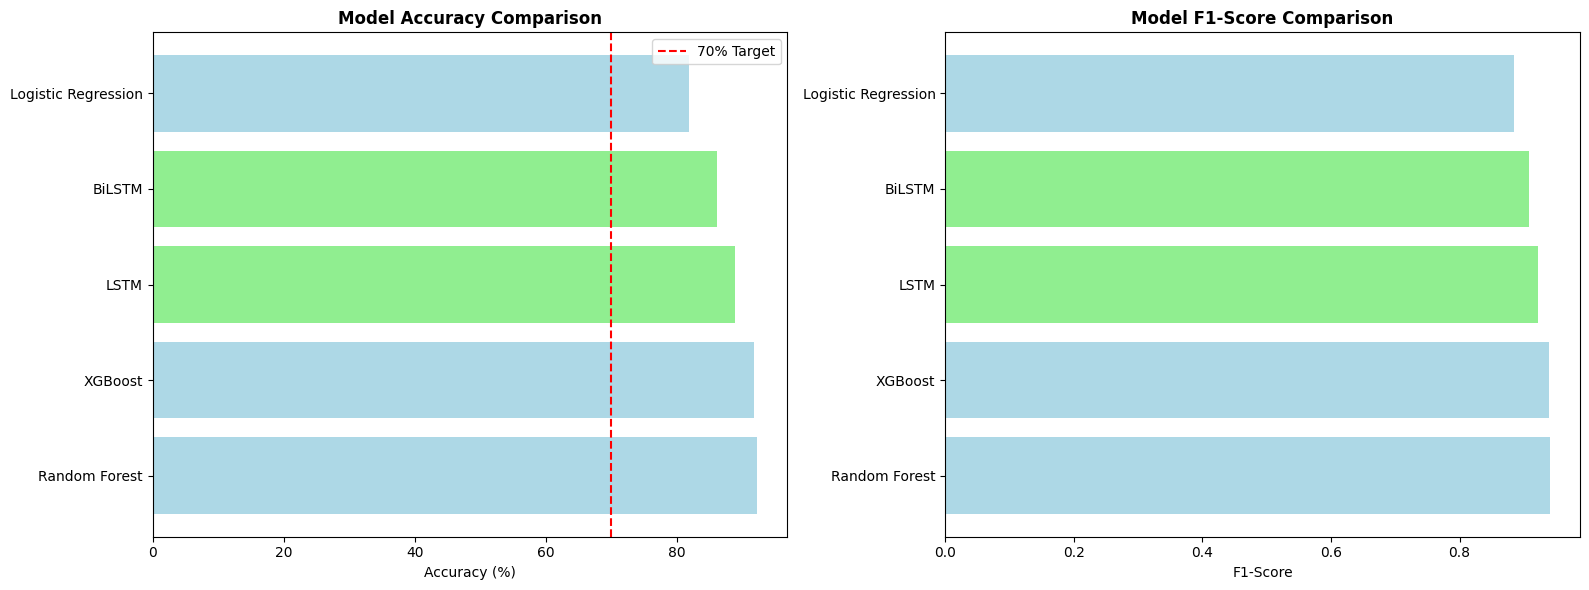

In [ ]:

print("\n" + "="*70)
print("[11/12] Model Comparison...")
print("="*70)

results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LSTM', 'BiLSTM'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy, lstm_accuracy, bilstm_accuracy],
    'F1-Score': [lr_f1, rf_f1, xgb_f1, lstm_f1, bilstm_f1],
    'Type': ['Baseline', 'Baseline', 'Baseline', 'Deep Learning', 'Deep Learning']
}).sort_values('Accuracy', ascending=False)

print("\n📊 RESULTS:")
print(results_df.to_string(index=False))

best = results_df.iloc[0]
print(f"\n🏆 BEST: {best['Model']} ({best['Accuracy']*100:.2f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['lightblue' if t == 'Baseline' else 'lightgreen' for t in results_df['Type']]
axes[0].barh(results_df['Model'], results_df['Accuracy']*100, color=colors)
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].axvline(x=70, color='red', linestyle='--', label='70% Target')
axes[0].legend()

axes[1].barh(results_df['Model'], results_df['F1-Score'], color=colors)
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Model F1-Score Comparison', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{output_dir}/06_model_comparison.png', dpi=150)
plt.show()


# SECTION 12: CONFUSION MATRICES & SUMMARY



[12/12] Final Summary...


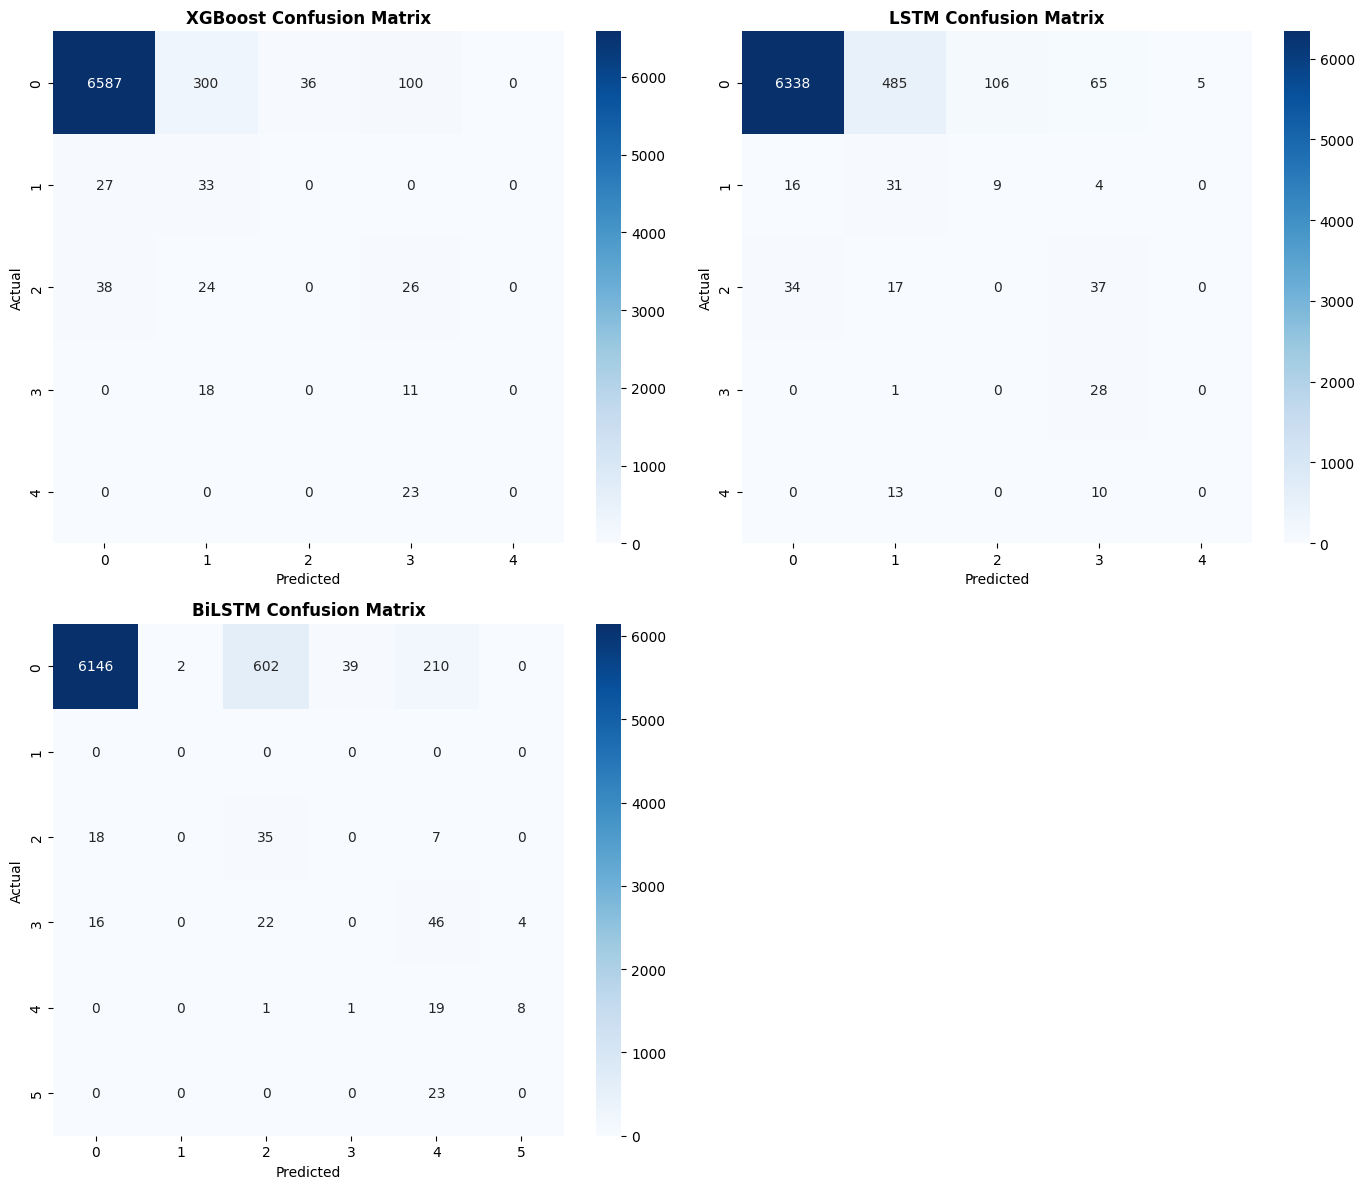


✅ TRAINING COMPLETE!

📊 Summary:
   Best model: Random Forest (92.33%)
   LSTM vs XGBoost: -2.94%

💾 Saved:
   Models: /content/drive/MyDrive/LoadShedding_Capstone/models/
   Results: /content/drive/MyDrive/LoadShedding_Capstone/outputs/model_results.csv
   Charts: /content/drive/MyDrive/LoadShedding_Capstone/outputs/06_model_comparison.png

🚀 Next: Week 6 - Prophet & Hybrid Models!


In [ ]:

print("\n" + "="*70)
print("[12/12] Final Summary...")
print("="*70)

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, (name, pred, ax) in enumerate([
    ('XGBoost', y_pred_xgb, axes[0, 0]),
    ('LSTM', y_pred_lstm, axes[0, 1]),
    ('BiLSTM', y_pred_bilstm, axes[1, 0])
]):
    y_true = y_test_seq if 'LSTM' in name else y_test
    cm = confusion_matrix(y_true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.savefig(f'{output_dir}/07_confusion_matrices.png', dpi=150)
plt.show()

# Save results
results_df.to_csv(f'{output_dir}/model_results.csv', index=False)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)

print(f"\n📊 Summary:")
print(f"   Best model: {best['Model']} ({best['Accuracy']*100:.2f}%)")
print(f"   LSTM vs XGBoost: {(lstm_accuracy - xgb_accuracy)*100:+.2f}%")

print(f"\n💾 Saved:")
print(f"   Models: {models_dir}/")
print(f"   Results: {output_dir}/model_results.csv")
print(f"   Charts: {output_dir}/06_model_comparison.png")

print(f"\n🚀 Next: Week 6 - Prophet & Hybrid Models!")
print("="*70)
